# Description
Your task is to create a neural network to classify images in the cifar100 dataset.
- You have to write the code from scratch, train the model and test the accuracy on the test set.
- You are not allowed to use pretrained models to do this task.
- You have to submit the .ipynb files with the execution result.

# Grading criteria
- You are graded on the test set accuracy:
  - Test accuracy = 0.50, Grade = 6
  - Test accuracy = 0.55, Grade = 7
  - Test accuracy = 0.60, Grade = 8
  - Test accuracy = 0.65, Grade = 9
  - Test accuracy = 0.70, Grade = 10
- Plagiarism will automatically results in 0 mark.


In [10]:
# DO NOT MODIFY THIS CODE
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from tqdm.auto import tqdm, trange

In [11]:
from tqdm import tqdm, trange
from torchsummary import summary
import math

In [12]:
train_transformer = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

testval_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

In [13]:
# DO NOT MODIFY THIS CODE
cifar100_train = datasets.CIFAR100('./data',
                             train=True,
                             download=True)

cifar100_test = datasets.CIFAR100('./data',
                              train=False,
                              download=True,
                              transform=testval_transformer)


In [14]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.subset)

In [15]:
train_size = int(0.9 * len(cifar100_train))
val_size = len(cifar100_train) - train_size
train_subset, val_subset = torch.utils.data.random_split(cifar100_train, [train_size, val_size])

new_cifar100_train = TransformedDataset(train_subset, train_transformer)
new_cifar100_val = TransformedDataset(val_subset, testval_transformer)

In [16]:
print(len(new_cifar100_train))
print(len(new_cifar100_val))
print(len(cifar100_test))

45000
5000
10000


In [17]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growthRate):
        super(Bottleneck, self).__init__()
        inter_channels = 4 * growthRate
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1, bias=False)
        self.dropout1 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm2d(inter_channels)
        self.conv2 = nn.Conv2d(inter_channels, growthRate, kernel_size=3, padding=1, bias=False)
        self.dropout2 = nn.Dropout(0.2)
    
    def forward(self, x):
        y = self.conv1(F.relu(self.bn1(x)))
        y = self.dropout1(y)
        y = self.conv2(F.relu(self.bn2(y)))
        y = self.dropout2(y)
        return y

In [18]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growthRate, nums_bottleneck):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(nums_bottleneck):
            layers.append(Bottleneck(in_channels=in_channels, growthRate=growthRate))
            in_channels += growthRate
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.net:
            y = layer(x)
            x = torch.cat((x, y), dim=1)
        return x

In [19]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.dropout1 = nn.Dropout(0.2)
    
    def forward(self, x):
        y = self.conv1(F.relu(self.bn1(x)))
        y = self.dropout1(y)
        y = F.avg_pool2d(y, kernel_size=2, stride=2)
        return y

In [20]:
# 100 layers - 1 initial layer - 1 final layer - 2 transition layer = 96 layers in dense blocks
# 3 dense blocks = 96 layers -> 1 dense block = 32 layers
# 2 layers = 1 bottleneck -> 1 dense block = 32 layers = 16 bottlenecks

In [21]:
class Net(nn.Module):
    def __init__(self, depth, growthRate, compression_factor, num_classes):
        super(Net, self).__init__()
        nums_bottleneck = (depth - 4) // 3 // 2      # (100 - 4) // 3 // 2 = 16  
        out_channels = 2 * growthRate    # Initialize out_channels

        self.initial_layer = nn.Conv2d(3, out_channels, kernel_size=3, padding=1, bias=False)       # Shape: (3, 32, 32) -> (24, 32, 32)

        self.dense_block_1 = DenseBlock(in_channels=out_channels, growthRate=growthRate, nums_bottleneck=nums_bottleneck)   # Shape: (24, 32, 32) -> (216, 32, 32)
        out_channels += growthRate * nums_bottleneck    # Update out_channels from 24 -> 216
        halved_channels = int(math.floor(out_channels * compression_factor))     # Halved_channels = 108
        self.transition_layer_1 = TransitionLayer(in_channels=out_channels, out_channels=halved_channels)       # Shape: (216, 32, 32) -> (108, 16, 16)

        out_channels = halved_channels      # Update out_channels from 216 -> 108

        self.dense_block_2 = DenseBlock(in_channels=out_channels, growthRate=growthRate, nums_bottleneck=nums_bottleneck)   # Shape: (108, 16, 16) -> (300, 16, 16)
        out_channels += growthRate * nums_bottleneck    # Update out_channels from 108 -> 300
        halved_channels = int(math.floor(out_channels * compression_factor))     # Halved_channels = 150
        self.transition_layer_2 = TransitionLayer(in_channels=out_channels, out_channels=halved_channels)       # Shape: (300, 16, 16)  -> (150, 8, 8)

        out_channels = halved_channels      # Update out_channels from 300 -> 150

        self.dense_block_3 = DenseBlock(in_channels=out_channels, growthRate=growthRate, nums_bottleneck=nums_bottleneck)   # Shape: (150, 8, 8) -> (342, 8, 8)
        out_channels += growthRate * nums_bottleneck    # Update out_channels 150 -> 342

        self.bn = nn.BatchNorm2d(out_channels)
        self.avg = nn.AdaptiveAvgPool2d((1, 1))     # Shape: (342, 8, 8) -> (342, 1, 1)
        self.flattener = nn.Flatten()               # Shape: (342, 1, 1) -> (342)
        self.classifier = nn.Linear(out_channels, num_classes)   # Shape: (342) -> (100)
    
    def forward(self, x):
        x = self.initial_layer(x)
        x = self.transition_layer_1(self.dense_block_1(x))
        x = self.transition_layer_2(self.dense_block_2(x))
        x = self.dense_block_3(x)
        x = F.relu(self.bn(x))
        x = self.avg(x)
        x = self.flattener(x)
        x = self.classifier(x)
        return x

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce RTX 3060


In [23]:
# L = 100, k = 12, theta = 0.5, 100 classes to classify
net = Net(depth=100, growthRate=12, compression_factor=0.5, num_classes=100).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 48, 32, 32]           1,152
           Dropout-4           [-1, 48, 32, 32]               0
       BatchNorm2d-5           [-1, 48, 32, 32]              96
            Conv2d-6           [-1, 12, 32, 32]           5,184
           Dropout-7           [-1, 12, 32, 32]               0
        Bottleneck-8           [-1, 12, 32, 32]               0
       BatchNorm2d-9           [-1, 36, 32, 32]              72
           Conv2d-10           [-1, 48, 32, 32]           1,728
          Dropout-11           [-1, 48, 32, 32]               0
      BatchNorm2d-12           [-1, 48, 32, 32]              96
           Conv2d-13           [-1, 12, 32, 32]           5,184
          Dropout-14           [-1, 12,

In [24]:
x = torch.rand((64, 3, 32, 32)).to(device)      # Test the Net
net(x).shape

torch.Size([64, 100])

In [25]:
# DO NOT MODIFY THIS CODE
def evaluate(net: nn.Module,
             data) -> float:
  """
  Evaluates the neural network on the given data.
  @param net: the neural network to evaluate
  @param data: the data to evaluate on
  @return: the accuracy of the neural network on the given data
  """
  data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=100,
                                            shuffle=False)

  correct = 0
  total = 0
  net.eval()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      pred_target = net(inputs).argmax(dim=1)
      correct += (pred_target == targets).sum().item()
      total += targets.size(0)

  return correct / total

In [26]:
def train(train_data,
          net,
          **kwargs) -> Tuple[nn.Module, list[float], list[float]]:
  """
  Trains the neural network on the given data.
  @param train_data: the data to train on
  @param net: the neural network to train
  @param kwargs: the keyword arguments such as learning rate, batch size, etc.
  @return: the trained neural network, train losses, and train accuracies
  """
  # NOTE: YOU ARE NOT ALLOWED TO PASS test_data AS A PARAMERTER TO THIS METHOD
  train_losses = []
  train_accuracies = []
  val_losses = []
 

  # YOUR CODE HERE
  # Hints: you are free to normalize the training data, invent new architecture,
  # apply early stopping, regularization, or any other kinds of tricks here.

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=kwargs['batch_size'],
                                             shuffle=True,
                                             num_workers=0)
  
  val_loader = torch.utils.data.DataLoader(kwargs['val_data'],
                                           batch_size=kwargs['batch_size'],
                                           shuffle=False)
  
  optimizer = opt.SGD(net.parameters(), lr=kwargs['lr'], momentum=0.9, weight_decay=1e-4, nesterov=True)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)
  criterion = nn.CrossEntropyLoss()

  pbar = trange(kwargs['epochs'])
  scaler = torch.GradScaler(device="cuda")

  for epoch in pbar:
    # Calculate train losses
    print(f"Starting epoch: {epoch}")
    net.train()
    train_loss = 0
    print(f"Length of train loader: {len(train_loader)}")
    for batch_idx, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      with torch.autocast(device_type="cuda"):
        pred_targets = net(inputs)
        loss = criterion(pred_targets, targets)
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Calculate val losses
    net.eval()
    val_loss = 0
    with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        pred_targets = net(inputs)
        loss = criterion(pred_targets, targets)
        val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Calculate train accuracy
    scheduler.step()
    train_accuracy = evaluate(net, train_data)
    train_accuracies.append(train_accuracy)

    # Set a description for tracking
    pbar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}  Accuracy: {train_accuracy:.4f}")

  return net, train_losses, val_losses, train_accuracies

In [27]:
lr = 0.1
batch_size = 64
epochs = 300
net, train_losses, val_losses, train_accuracies = train(train_data=new_cifar100_train,
                                            net=net,
                                            lr=lr,
                                            optimizer='adam',
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            val_data=new_cifar100_val)

  0%|          | 0/300 [00:00<?, ?it/s]

Starting epoch: 0
Length of train loader: 704


Epoch: 0, Train Loss: 3.9218, Val Loss: 3.9335  Accuracy: 0.1266:   0%|          | 1/300 [01:23<6:55:07, 83.30s/it]

Starting epoch: 1
Length of train loader: 704


Epoch: 1, Train Loss: 3.2449, Val Loss: 3.4005  Accuracy: 0.2146:   1%|          | 2/300 [02:44<6:48:06, 82.17s/it]

Starting epoch: 2
Length of train loader: 704


Epoch: 2, Train Loss: 2.7179, Val Loss: 2.9053  Accuracy: 0.3254:   1%|          | 3/300 [04:04<6:40:56, 81.00s/it]

Starting epoch: 3
Length of train loader: 704


Epoch: 3, Train Loss: 2.3757, Val Loss: 2.9311  Accuracy: 0.3370:   1%|▏         | 4/300 [05:23<6:36:50, 80.44s/it]

Starting epoch: 4
Length of train loader: 704


Epoch: 4, Train Loss: 2.1525, Val Loss: 2.8983  Accuracy: 0.3885:   2%|▏         | 5/300 [06:43<6:34:12, 80.18s/it]

Starting epoch: 5
Length of train loader: 704


Epoch: 5, Train Loss: 1.9907, Val Loss: 3.2405  Accuracy: 0.3804:   2%|▏         | 6/300 [08:03<6:31:55, 79.99s/it]

Starting epoch: 6
Length of train loader: 704


Epoch: 6, Train Loss: 1.8790, Val Loss: 2.3849  Accuracy: 0.4674:   2%|▏         | 7/300 [09:22<6:29:54, 79.85s/it]

Starting epoch: 7
Length of train loader: 704


Epoch: 7, Train Loss: 1.7813, Val Loss: 2.0922  Accuracy: 0.5213:   3%|▎         | 8/300 [10:42<6:28:09, 79.76s/it]

Starting epoch: 8
Length of train loader: 704


Epoch: 8, Train Loss: 1.7147, Val Loss: 2.1200  Accuracy: 0.5319:   3%|▎         | 9/300 [12:01<6:26:34, 79.71s/it]

Starting epoch: 9
Length of train loader: 704


Epoch: 9, Train Loss: 1.6534, Val Loss: 1.9161  Accuracy: 0.5529:   3%|▎         | 10/300 [13:21<6:25:11, 79.70s/it]

Starting epoch: 10
Length of train loader: 704


Epoch: 10, Train Loss: 1.5993, Val Loss: 2.2142  Accuracy: 0.5226:   4%|▎         | 11/300 [14:41<6:23:42, 79.66s/it]

Starting epoch: 11
Length of train loader: 704


Epoch: 11, Train Loss: 1.5649, Val Loss: 2.1215  Accuracy: 0.5320:   4%|▍         | 12/300 [16:00<6:22:20, 79.65s/it]

Starting epoch: 12
Length of train loader: 704


Epoch: 12, Train Loss: 1.5213, Val Loss: 1.9237  Accuracy: 0.5717:   4%|▍         | 13/300 [17:20<6:20:57, 79.64s/it]

Starting epoch: 13
Length of train loader: 704


Epoch: 13, Train Loss: 1.4857, Val Loss: 1.9265  Accuracy: 0.5871:   5%|▍         | 14/300 [18:39<6:19:29, 79.61s/it]

Starting epoch: 14
Length of train loader: 704


Epoch: 14, Train Loss: 1.4583, Val Loss: 2.0523  Accuracy: 0.5797:   5%|▌         | 15/300 [19:59<6:18:11, 79.62s/it]

Starting epoch: 15
Length of train loader: 704


Epoch: 15, Train Loss: 1.4225, Val Loss: 1.8984  Accuracy: 0.5787:   5%|▌         | 16/300 [21:19<6:16:48, 79.61s/it]

Starting epoch: 16
Length of train loader: 704


Epoch: 16, Train Loss: 1.4072, Val Loss: 2.1290  Accuracy: 0.5437:   6%|▌         | 17/300 [22:38<6:15:30, 79.61s/it]

Starting epoch: 17
Length of train loader: 704


Epoch: 17, Train Loss: 1.3809, Val Loss: 1.8274  Accuracy: 0.6120:   6%|▌         | 18/300 [23:58<6:14:09, 79.61s/it]

Starting epoch: 18
Length of train loader: 704


Epoch: 18, Train Loss: 1.3620, Val Loss: 1.8773  Accuracy: 0.5873:   6%|▋         | 19/300 [25:18<6:12:49, 79.61s/it]

Starting epoch: 19
Length of train loader: 704


Epoch: 19, Train Loss: 1.3506, Val Loss: 1.9268  Accuracy: 0.5968:   7%|▋         | 20/300 [26:37<6:11:27, 79.60s/it]

Starting epoch: 20
Length of train loader: 704


Epoch: 20, Train Loss: 1.3319, Val Loss: 2.3536  Accuracy: 0.5378:   7%|▋         | 21/300 [27:57<6:10:41, 79.72s/it]

Starting epoch: 21
Length of train loader: 704


Epoch: 21, Train Loss: 1.3150, Val Loss: 1.7466  Accuracy: 0.6237:   7%|▋         | 22/300 [29:20<6:13:39, 80.64s/it]

Starting epoch: 22
Length of train loader: 704


Epoch: 22, Train Loss: 1.3060, Val Loss: 1.7592  Accuracy: 0.6369:   8%|▊         | 23/300 [30:59<6:37:40, 86.14s/it]

Starting epoch: 23
Length of train loader: 704


Epoch: 23, Train Loss: 1.2791, Val Loss: 1.6258  Accuracy: 0.6525:   8%|▊         | 24/300 [32:41<6:58:18, 90.94s/it]

Starting epoch: 24
Length of train loader: 704


Epoch: 24, Train Loss: 1.2644, Val Loss: 1.7540  Accuracy: 0.6312:   8%|▊         | 25/300 [34:23<7:11:54, 94.24s/it]

Starting epoch: 25
Length of train loader: 704


Epoch: 25, Train Loss: 1.2655, Val Loss: 1.6199  Accuracy: 0.6447:   9%|▊         | 26/300 [35:46<6:55:20, 90.95s/it]

Starting epoch: 26
Length of train loader: 704


Epoch: 26, Train Loss: 1.2479, Val Loss: 1.5511  Accuracy: 0.6688:   9%|▉         | 27/300 [37:06<6:37:56, 87.46s/it]

Starting epoch: 27
Length of train loader: 704


Epoch: 27, Train Loss: 1.2326, Val Loss: 1.8909  Accuracy: 0.6246:   9%|▉         | 28/300 [38:25<6:25:09, 84.96s/it]

Starting epoch: 28
Length of train loader: 704


Epoch: 28, Train Loss: 1.2283, Val Loss: 1.9054  Accuracy: 0.6222:  10%|▉         | 29/300 [39:44<6:15:56, 83.24s/it]

Starting epoch: 29
Length of train loader: 704


Epoch: 29, Train Loss: 1.2153, Val Loss: 1.5067  Accuracy: 0.6923:  10%|█         | 30/300 [41:03<6:09:03, 82.01s/it]

Starting epoch: 30
Length of train loader: 704


Epoch: 30, Train Loss: 1.2051, Val Loss: 2.1639  Accuracy: 0.5990:  10%|█         | 31/300 [42:22<6:03:51, 81.16s/it]

Starting epoch: 31
Length of train loader: 704


Epoch: 31, Train Loss: 1.2060, Val Loss: 1.7713  Accuracy: 0.6631:  11%|█         | 32/300 [43:41<5:59:23, 80.46s/it]

Starting epoch: 32
Length of train loader: 704


Epoch: 32, Train Loss: 1.1926, Val Loss: 1.5238  Accuracy: 0.7028:  11%|█         | 33/300 [45:00<5:56:19, 80.07s/it]

Starting epoch: 33
Length of train loader: 704


Epoch: 33, Train Loss: 1.1780, Val Loss: 1.9737  Accuracy: 0.6325:  11%|█▏        | 34/300 [46:19<5:53:37, 79.77s/it]

Starting epoch: 34
Length of train loader: 704


Epoch: 34, Train Loss: 1.1889, Val Loss: 1.7926  Accuracy: 0.6400:  12%|█▏        | 35/300 [47:38<5:51:34, 79.60s/it]

Starting epoch: 35
Length of train loader: 704


Epoch: 35, Train Loss: 1.1726, Val Loss: 1.5712  Accuracy: 0.6766:  12%|█▏        | 36/300 [48:58<5:49:35, 79.45s/it]

Starting epoch: 36
Length of train loader: 704


Epoch: 36, Train Loss: 1.1597, Val Loss: 1.6811  Accuracy: 0.6582:  12%|█▏        | 37/300 [50:17<5:47:53, 79.37s/it]

Starting epoch: 37
Length of train loader: 704


Epoch: 37, Train Loss: 1.1604, Val Loss: 1.5524  Accuracy: 0.6996:  13%|█▎        | 38/300 [51:36<5:46:23, 79.33s/it]

Starting epoch: 38
Length of train loader: 704


Epoch: 38, Train Loss: 1.1463, Val Loss: 1.7001  Accuracy: 0.6689:  13%|█▎        | 39/300 [52:55<5:44:51, 79.28s/it]

Starting epoch: 39
Length of train loader: 704


Epoch: 39, Train Loss: 1.1383, Val Loss: 1.7049  Accuracy: 0.6461:  13%|█▎        | 40/300 [54:14<5:43:20, 79.23s/it]

Starting epoch: 40
Length of train loader: 704


Epoch: 40, Train Loss: 1.1404, Val Loss: 1.6057  Accuracy: 0.6831:  14%|█▎        | 41/300 [55:33<5:41:44, 79.17s/it]

Starting epoch: 41
Length of train loader: 704


Epoch: 41, Train Loss: 1.1407, Val Loss: 1.6678  Accuracy: 0.6800:  14%|█▍        | 42/300 [56:52<5:40:25, 79.17s/it]

Starting epoch: 42
Length of train loader: 704


Epoch: 42, Train Loss: 1.1267, Val Loss: 1.5715  Accuracy: 0.6820:  14%|█▍        | 43/300 [58:11<5:38:34, 79.05s/it]

Starting epoch: 43
Length of train loader: 704


Epoch: 43, Train Loss: 1.1217, Val Loss: 1.5041  Accuracy: 0.6975:  15%|█▍        | 44/300 [59:30<5:37:04, 79.00s/it]

Starting epoch: 44
Length of train loader: 704


Epoch: 44, Train Loss: 1.1183, Val Loss: 1.7087  Accuracy: 0.6698:  15%|█▌        | 45/300 [1:00:49<5:35:46, 79.00s/it]

Starting epoch: 45
Length of train loader: 704


Epoch: 45, Train Loss: 1.1117, Val Loss: 1.7511  Accuracy: 0.6700:  15%|█▌        | 46/300 [1:02:08<5:34:27, 79.01s/it]

Starting epoch: 46
Length of train loader: 704


Epoch: 46, Train Loss: 1.1193, Val Loss: 1.5089  Accuracy: 0.7088:  16%|█▌        | 47/300 [1:03:27<5:33:31, 79.10s/it]

Starting epoch: 47
Length of train loader: 704


Epoch: 47, Train Loss: 1.1078, Val Loss: 1.5833  Accuracy: 0.7048:  16%|█▌        | 48/300 [1:04:47<5:32:23, 79.14s/it]

Starting epoch: 48
Length of train loader: 704


Epoch: 48, Train Loss: 1.0961, Val Loss: 1.7603  Accuracy: 0.6679:  16%|█▋        | 49/300 [1:06:06<5:31:20, 79.21s/it]

Starting epoch: 49
Length of train loader: 704


Epoch: 49, Train Loss: 1.0989, Val Loss: 1.5097  Accuracy: 0.7102:  17%|█▋        | 50/300 [1:07:25<5:30:06, 79.23s/it]

Starting epoch: 50
Length of train loader: 704


Epoch: 50, Train Loss: 1.0928, Val Loss: 1.6299  Accuracy: 0.6925:  17%|█▋        | 51/300 [1:08:44<5:28:35, 79.18s/it]

Starting epoch: 51
Length of train loader: 704


Epoch: 51, Train Loss: 1.0986, Val Loss: 1.5206  Accuracy: 0.6985:  17%|█▋        | 52/300 [1:10:04<5:27:27, 79.22s/it]

Starting epoch: 52
Length of train loader: 704


Epoch: 52, Train Loss: 1.0973, Val Loss: 1.4222  Accuracy: 0.7182:  18%|█▊        | 53/300 [1:11:23<5:25:47, 79.14s/it]

Starting epoch: 53
Length of train loader: 704


Epoch: 53, Train Loss: 1.0809, Val Loss: 1.3850  Accuracy: 0.7299:  18%|█▊        | 54/300 [1:12:42<5:24:33, 79.16s/it]

Starting epoch: 54
Length of train loader: 704


Epoch: 54, Train Loss: 1.0875, Val Loss: 1.7000  Accuracy: 0.6750:  18%|█▊        | 55/300 [1:14:01<5:23:23, 79.20s/it]

Starting epoch: 55
Length of train loader: 704


Epoch: 55, Train Loss: 1.0961, Val Loss: 1.6822  Accuracy: 0.6841:  19%|█▊        | 56/300 [1:15:20<5:22:14, 79.24s/it]

Starting epoch: 56
Length of train loader: 704


Epoch: 56, Train Loss: 1.0839, Val Loss: 1.5508  Accuracy: 0.7055:  19%|█▉        | 57/300 [1:16:40<5:21:06, 79.29s/it]

Starting epoch: 57
Length of train loader: 704


Epoch: 57, Train Loss: 1.0724, Val Loss: 1.7129  Accuracy: 0.6516:  19%|█▉        | 58/300 [1:17:59<5:19:51, 79.30s/it]

Starting epoch: 58
Length of train loader: 704


Epoch: 58, Train Loss: 1.0781, Val Loss: 1.6478  Accuracy: 0.7048:  20%|█▉        | 59/300 [1:19:19<5:18:34, 79.31s/it]

Starting epoch: 59
Length of train loader: 704


Epoch: 59, Train Loss: 1.0664, Val Loss: 1.6819  Accuracy: 0.6811:  20%|██        | 60/300 [1:20:38<5:17:12, 79.30s/it]

Starting epoch: 60
Length of train loader: 704


Epoch: 60, Train Loss: 1.0709, Val Loss: 1.6869  Accuracy: 0.6807:  20%|██        | 61/300 [1:21:57<5:15:52, 79.30s/it]

Starting epoch: 61
Length of train loader: 704


Epoch: 61, Train Loss: 1.0658, Val Loss: 1.5546  Accuracy: 0.6939:  21%|██        | 62/300 [1:23:16<5:14:32, 79.30s/it]

Starting epoch: 62
Length of train loader: 704


Epoch: 62, Train Loss: 1.0657, Val Loss: 1.6218  Accuracy: 0.7023:  21%|██        | 63/300 [1:24:36<5:13:10, 79.29s/it]

Starting epoch: 63
Length of train loader: 704


Epoch: 63, Train Loss: 1.0588, Val Loss: 1.5443  Accuracy: 0.6998:  21%|██▏       | 64/300 [1:25:55<5:11:57, 79.31s/it]

Starting epoch: 64
Length of train loader: 704


Epoch: 64, Train Loss: 1.0622, Val Loss: 1.3477  Accuracy: 0.7313:  22%|██▏       | 65/300 [1:27:14<5:10:39, 79.32s/it]

Starting epoch: 65
Length of train loader: 704


Epoch: 65, Train Loss: 1.0533, Val Loss: 1.4938  Accuracy: 0.7119:  22%|██▏       | 66/300 [1:28:34<5:09:20, 79.32s/it]

Starting epoch: 66
Length of train loader: 704


Epoch: 66, Train Loss: 1.0524, Val Loss: 1.6286  Accuracy: 0.6951:  22%|██▏       | 67/300 [1:29:53<5:08:05, 79.34s/it]

Starting epoch: 67
Length of train loader: 704


Epoch: 67, Train Loss: 1.0643, Val Loss: 1.5650  Accuracy: 0.6931:  23%|██▎       | 68/300 [1:31:12<5:06:37, 79.30s/it]

Starting epoch: 68
Length of train loader: 704


Epoch: 68, Train Loss: 1.0546, Val Loss: 1.6566  Accuracy: 0.6848:  23%|██▎       | 69/300 [1:32:32<5:05:17, 79.30s/it]

Starting epoch: 69
Length of train loader: 704


Epoch: 69, Train Loss: 1.0464, Val Loss: 1.7900  Accuracy: 0.6863:  23%|██▎       | 70/300 [1:33:51<5:03:53, 79.28s/it]

Starting epoch: 70
Length of train loader: 704


Epoch: 70, Train Loss: 1.0471, Val Loss: 1.5935  Accuracy: 0.6910:  24%|██▎       | 71/300 [1:35:10<5:02:22, 79.22s/it]

Starting epoch: 71
Length of train loader: 704


Epoch: 71, Train Loss: 1.0392, Val Loss: 1.4849  Accuracy: 0.7092:  24%|██▍       | 72/300 [1:36:29<5:00:35, 79.10s/it]

Starting epoch: 72
Length of train loader: 704


Epoch: 72, Train Loss: 1.0440, Val Loss: 1.4597  Accuracy: 0.7288:  24%|██▍       | 73/300 [1:37:48<4:59:32, 79.17s/it]

Starting epoch: 73
Length of train loader: 704


Epoch: 73, Train Loss: 1.0329, Val Loss: 1.6376  Accuracy: 0.7027:  25%|██▍       | 74/300 [1:39:07<4:58:22, 79.21s/it]

Starting epoch: 74
Length of train loader: 704


Epoch: 74, Train Loss: 1.0421, Val Loss: 1.6983  Accuracy: 0.6871:  25%|██▌       | 75/300 [1:40:27<4:57:02, 79.21s/it]

Starting epoch: 75
Length of train loader: 704


Epoch: 75, Train Loss: 1.0360, Val Loss: 1.6560  Accuracy: 0.6771:  25%|██▌       | 76/300 [1:41:46<4:55:46, 79.22s/it]

Starting epoch: 76
Length of train loader: 704


Epoch: 76, Train Loss: 1.0350, Val Loss: 1.8290  Accuracy: 0.6806:  26%|██▌       | 77/300 [1:43:05<4:54:26, 79.22s/it]

Starting epoch: 77
Length of train loader: 704


Epoch: 77, Train Loss: 1.0393, Val Loss: 1.4440  Accuracy: 0.7201:  26%|██▌       | 78/300 [1:44:24<4:53:02, 79.20s/it]

Starting epoch: 78
Length of train loader: 704


Epoch: 78, Train Loss: 1.0264, Val Loss: 1.6396  Accuracy: 0.6924:  26%|██▋       | 79/300 [1:45:43<4:51:29, 79.14s/it]

Starting epoch: 79
Length of train loader: 704


Epoch: 79, Train Loss: 1.0295, Val Loss: 2.0655  Accuracy: 0.6285:  27%|██▋       | 80/300 [1:47:02<4:50:20, 79.18s/it]

Starting epoch: 80
Length of train loader: 704


Epoch: 80, Train Loss: 1.0354, Val Loss: 1.6401  Accuracy: 0.6976:  27%|██▋       | 81/300 [1:48:22<4:49:02, 79.19s/it]

Starting epoch: 81
Length of train loader: 704


Epoch: 81, Train Loss: 1.0176, Val Loss: 1.4176  Accuracy: 0.7441:  27%|██▋       | 82/300 [1:49:41<4:47:50, 79.22s/it]

Starting epoch: 82
Length of train loader: 704


Epoch: 82, Train Loss: 1.0192, Val Loss: 1.7356  Accuracy: 0.6761:  28%|██▊       | 83/300 [1:51:00<4:46:38, 79.25s/it]

Starting epoch: 83
Length of train loader: 704


Epoch: 83, Train Loss: 1.0307, Val Loss: 1.6282  Accuracy: 0.6927:  28%|██▊       | 84/300 [1:52:19<4:44:58, 79.16s/it]

Starting epoch: 84
Length of train loader: 704


Epoch: 84, Train Loss: 1.0192, Val Loss: 1.6839  Accuracy: 0.6935:  28%|██▊       | 85/300 [1:53:38<4:43:45, 79.19s/it]

Starting epoch: 85
Length of train loader: 704


Epoch: 85, Train Loss: 1.0218, Val Loss: 1.6273  Accuracy: 0.6921:  29%|██▊       | 86/300 [1:54:57<4:42:10, 79.12s/it]

Starting epoch: 86
Length of train loader: 704


Epoch: 86, Train Loss: 1.0175, Val Loss: 1.6875  Accuracy: 0.6868:  29%|██▉       | 87/300 [1:56:17<4:40:57, 79.14s/it]

Starting epoch: 87
Length of train loader: 704


Epoch: 87, Train Loss: 1.0179, Val Loss: 1.5098  Accuracy: 0.7245:  29%|██▉       | 88/300 [1:57:36<4:39:50, 79.20s/it]

Starting epoch: 88
Length of train loader: 704


Epoch: 88, Train Loss: 1.0093, Val Loss: 1.7672  Accuracy: 0.6774:  30%|██▉       | 89/300 [1:58:55<4:38:42, 79.25s/it]

Starting epoch: 89
Length of train loader: 704


Epoch: 89, Train Loss: 1.0093, Val Loss: 1.4404  Accuracy: 0.7272:  30%|███       | 90/300 [2:00:15<4:37:18, 79.23s/it]

Starting epoch: 90
Length of train loader: 704


Epoch: 90, Train Loss: 1.0089, Val Loss: 1.6364  Accuracy: 0.6918:  30%|███       | 91/300 [2:01:34<4:36:01, 79.24s/it]

Starting epoch: 91
Length of train loader: 704


Epoch: 91, Train Loss: 1.0068, Val Loss: 1.5433  Accuracy: 0.7185:  31%|███       | 92/300 [2:02:53<4:34:42, 79.24s/it]

Starting epoch: 92
Length of train loader: 704


Epoch: 92, Train Loss: 1.0169, Val Loss: 1.6757  Accuracy: 0.6986:  31%|███       | 93/300 [2:04:12<4:33:27, 79.26s/it]

Starting epoch: 93
Length of train loader: 704


Epoch: 93, Train Loss: 1.0100, Val Loss: 1.6292  Accuracy: 0.6917:  31%|███▏      | 94/300 [2:05:32<4:32:15, 79.30s/it]

Starting epoch: 94
Length of train loader: 704


Epoch: 94, Train Loss: 1.0123, Val Loss: 1.5956  Accuracy: 0.7080:  32%|███▏      | 95/300 [2:06:51<4:30:56, 79.30s/it]

Starting epoch: 95
Length of train loader: 704


Epoch: 95, Train Loss: 0.9992, Val Loss: 1.4685  Accuracy: 0.7314:  32%|███▏      | 96/300 [2:08:10<4:29:22, 79.23s/it]

Starting epoch: 96
Length of train loader: 704


Epoch: 96, Train Loss: 1.0044, Val Loss: 1.7104  Accuracy: 0.6896:  32%|███▏      | 97/300 [2:09:29<4:27:57, 79.20s/it]

Starting epoch: 97
Length of train loader: 704


Epoch: 97, Train Loss: 1.0038, Val Loss: 1.4873  Accuracy: 0.7378:  33%|███▎      | 98/300 [2:10:49<4:26:43, 79.23s/it]

Starting epoch: 98
Length of train loader: 704


Epoch: 98, Train Loss: 0.9978, Val Loss: 1.6990  Accuracy: 0.6727:  33%|███▎      | 99/300 [2:12:08<4:25:37, 79.29s/it]

Starting epoch: 99
Length of train loader: 704


Epoch: 99, Train Loss: 1.0078, Val Loss: 1.4581  Accuracy: 0.7228:  33%|███▎      | 100/300 [2:13:27<4:24:19, 79.30s/it]

Starting epoch: 100
Length of train loader: 704


Epoch: 100, Train Loss: 0.9974, Val Loss: 1.7940  Accuracy: 0.6764:  34%|███▎      | 101/300 [2:14:47<4:22:57, 79.29s/it]

Starting epoch: 101
Length of train loader: 704


Epoch: 101, Train Loss: 1.0020, Val Loss: 1.5453  Accuracy: 0.7100:  34%|███▍      | 102/300 [2:16:06<4:21:43, 79.31s/it]

Starting epoch: 102
Length of train loader: 704


Epoch: 102, Train Loss: 1.0001, Val Loss: 1.4382  Accuracy: 0.7147:  34%|███▍      | 103/300 [2:17:25<4:20:14, 79.26s/it]

Starting epoch: 103
Length of train loader: 704


Epoch: 103, Train Loss: 0.9915, Val Loss: 1.5609  Accuracy: 0.7078:  35%|███▍      | 104/300 [2:18:44<4:19:01, 79.29s/it]

Starting epoch: 104
Length of train loader: 704


Epoch: 104, Train Loss: 0.9896, Val Loss: 1.4484  Accuracy: 0.7391:  35%|███▌      | 105/300 [2:20:04<4:17:38, 79.27s/it]

Starting epoch: 105
Length of train loader: 704


Epoch: 105, Train Loss: 0.9980, Val Loss: 1.5901  Accuracy: 0.7266:  35%|███▌      | 106/300 [2:21:23<4:16:23, 79.30s/it]

Starting epoch: 106
Length of train loader: 704


Epoch: 106, Train Loss: 0.9850, Val Loss: 1.7153  Accuracy: 0.6965:  36%|███▌      | 107/300 [2:22:42<4:14:55, 79.25s/it]

Starting epoch: 107
Length of train loader: 704


Epoch: 107, Train Loss: 1.0030, Val Loss: 1.4204  Accuracy: 0.7488:  36%|███▌      | 108/300 [2:24:01<4:13:33, 79.24s/it]

Starting epoch: 108
Length of train loader: 704


Epoch: 108, Train Loss: 1.0033, Val Loss: 1.6940  Accuracy: 0.6939:  36%|███▋      | 109/300 [2:25:20<4:12:06, 79.20s/it]

Starting epoch: 109
Length of train loader: 704


Epoch: 109, Train Loss: 0.9932, Val Loss: 1.3580  Accuracy: 0.7556:  37%|███▋      | 110/300 [2:26:40<4:10:49, 79.21s/it]

Starting epoch: 110
Length of train loader: 704


Epoch: 110, Train Loss: 0.9903, Val Loss: 1.5487  Accuracy: 0.7309:  37%|███▋      | 111/300 [2:27:59<4:09:38, 79.25s/it]

Starting epoch: 111
Length of train loader: 704


Epoch: 111, Train Loss: 0.9908, Val Loss: 1.5811  Accuracy: 0.6997:  37%|███▋      | 112/300 [2:29:18<4:08:19, 79.25s/it]

Starting epoch: 112
Length of train loader: 704


Epoch: 112, Train Loss: 0.9855, Val Loss: 1.5093  Accuracy: 0.7224:  38%|███▊      | 113/300 [2:30:38<4:07:04, 79.27s/it]

Starting epoch: 113
Length of train loader: 704


Epoch: 113, Train Loss: 0.9871, Val Loss: 1.4390  Accuracy: 0.7084:  38%|███▊      | 114/300 [2:31:57<4:05:49, 79.30s/it]

Starting epoch: 114
Length of train loader: 704


Epoch: 114, Train Loss: 0.9866, Val Loss: 1.5061  Accuracy: 0.7316:  38%|███▊      | 115/300 [2:33:16<4:04:34, 79.32s/it]

Starting epoch: 115
Length of train loader: 704


Epoch: 115, Train Loss: 0.9885, Val Loss: 1.3927  Accuracy: 0.7432:  39%|███▊      | 116/300 [2:34:36<4:03:11, 79.30s/it]

Starting epoch: 116
Length of train loader: 704


Epoch: 116, Train Loss: 0.9890, Val Loss: 1.6607  Accuracy: 0.7153:  39%|███▉      | 117/300 [2:35:55<4:01:39, 79.23s/it]

Starting epoch: 117
Length of train loader: 704


Epoch: 117, Train Loss: 0.9836, Val Loss: 1.4399  Accuracy: 0.7211:  39%|███▉      | 118/300 [2:37:14<4:00:23, 79.25s/it]

Starting epoch: 118
Length of train loader: 704


Epoch: 118, Train Loss: 0.9876, Val Loss: 1.4875  Accuracy: 0.7161:  40%|███▉      | 119/300 [2:38:33<3:59:09, 79.28s/it]

Starting epoch: 119
Length of train loader: 704


Epoch: 119, Train Loss: 0.9829, Val Loss: 1.4326  Accuracy: 0.7382:  40%|████      | 120/300 [2:39:52<3:57:38, 79.21s/it]

Starting epoch: 120
Length of train loader: 704


Epoch: 120, Train Loss: 0.9815, Val Loss: 1.7377  Accuracy: 0.6706:  40%|████      | 121/300 [2:41:12<3:56:26, 79.26s/it]

Starting epoch: 121
Length of train loader: 704


Epoch: 121, Train Loss: 0.9840, Val Loss: 1.4951  Accuracy: 0.7169:  41%|████      | 122/300 [2:42:31<3:55:11, 79.28s/it]

Starting epoch: 122
Length of train loader: 704


Epoch: 122, Train Loss: 0.9794, Val Loss: 1.4417  Accuracy: 0.7312:  41%|████      | 123/300 [2:43:50<3:53:57, 79.31s/it]

Starting epoch: 123
Length of train loader: 704


Epoch: 123, Train Loss: 0.9742, Val Loss: 1.4029  Accuracy: 0.7360:  41%|████▏     | 124/300 [2:45:10<3:52:42, 79.33s/it]

Starting epoch: 124
Length of train loader: 704


Epoch: 124, Train Loss: 0.9772, Val Loss: 1.6864  Accuracy: 0.6946:  42%|████▏     | 125/300 [2:46:29<3:51:25, 79.35s/it]

Starting epoch: 125
Length of train loader: 704


Epoch: 125, Train Loss: 0.9863, Val Loss: 1.6470  Accuracy: 0.6993:  42%|████▏     | 126/300 [2:47:49<3:50:07, 79.35s/it]

Starting epoch: 126
Length of train loader: 704


Epoch: 126, Train Loss: 0.9790, Val Loss: 1.4671  Accuracy: 0.7314:  42%|████▏     | 127/300 [2:49:08<3:48:48, 79.36s/it]

Starting epoch: 127
Length of train loader: 704


Epoch: 127, Train Loss: 0.9680, Val Loss: 1.4690  Accuracy: 0.7275:  43%|████▎     | 128/300 [2:50:27<3:47:28, 79.35s/it]

Starting epoch: 128
Length of train loader: 704


Epoch: 128, Train Loss: 0.9786, Val Loss: 1.4058  Accuracy: 0.7288:  43%|████▎     | 129/300 [2:51:47<3:46:08, 79.35s/it]

Starting epoch: 129
Length of train loader: 704


Epoch: 129, Train Loss: 0.9756, Val Loss: 1.4937  Accuracy: 0.7340:  43%|████▎     | 130/300 [2:53:06<3:44:47, 79.34s/it]

Starting epoch: 130
Length of train loader: 704


Epoch: 130, Train Loss: 0.9719, Val Loss: 1.5342  Accuracy: 0.7165:  44%|████▎     | 131/300 [2:54:25<3:43:27, 79.33s/it]

Starting epoch: 131
Length of train loader: 704


Epoch: 131, Train Loss: 0.9758, Val Loss: 1.6558  Accuracy: 0.7054:  44%|████▍     | 132/300 [2:55:44<3:41:56, 79.26s/it]

Starting epoch: 132
Length of train loader: 704


Epoch: 132, Train Loss: 0.9844, Val Loss: 1.3248  Accuracy: 0.7416:  44%|████▍     | 133/300 [2:57:03<3:40:25, 79.19s/it]

Starting epoch: 133
Length of train loader: 704


Epoch: 133, Train Loss: 0.9707, Val Loss: 1.5752  Accuracy: 0.7137:  45%|████▍     | 134/300 [2:58:23<3:39:15, 79.25s/it]

Starting epoch: 134
Length of train loader: 704


Epoch: 134, Train Loss: 0.9655, Val Loss: 1.5085  Accuracy: 0.7336:  45%|████▌     | 135/300 [2:59:42<3:37:44, 79.18s/it]

Starting epoch: 135
Length of train loader: 704


Epoch: 135, Train Loss: 0.9689, Val Loss: 1.4600  Accuracy: 0.7311:  45%|████▌     | 136/300 [3:01:01<3:36:30, 79.21s/it]

Starting epoch: 136
Length of train loader: 704


Epoch: 136, Train Loss: 0.9778, Val Loss: 1.2986  Accuracy: 0.7582:  46%|████▌     | 137/300 [3:02:20<3:35:08, 79.19s/it]

Starting epoch: 137
Length of train loader: 704


Epoch: 137, Train Loss: 0.9669, Val Loss: 1.5109  Accuracy: 0.7243:  46%|████▌     | 138/300 [3:03:40<3:33:55, 79.23s/it]

Starting epoch: 138
Length of train loader: 704


Epoch: 138, Train Loss: 0.9743, Val Loss: 1.6302  Accuracy: 0.7051:  46%|████▋     | 139/300 [3:04:59<3:32:41, 79.26s/it]

Starting epoch: 139
Length of train loader: 704


Epoch: 139, Train Loss: 0.9667, Val Loss: 1.5311  Accuracy: 0.7185:  47%|████▋     | 140/300 [3:06:18<3:31:24, 79.28s/it]

Starting epoch: 140
Length of train loader: 704


Epoch: 140, Train Loss: 0.9613, Val Loss: 1.4314  Accuracy: 0.7435:  47%|████▋     | 141/300 [3:07:37<3:30:04, 79.27s/it]

Starting epoch: 141
Length of train loader: 704


Epoch: 141, Train Loss: 0.9627, Val Loss: 1.5163  Accuracy: 0.7243:  47%|████▋     | 142/300 [3:08:57<3:28:40, 79.24s/it]

Starting epoch: 142
Length of train loader: 704


Epoch: 142, Train Loss: 0.9669, Val Loss: 1.5945  Accuracy: 0.7218:  48%|████▊     | 143/300 [3:10:16<3:27:13, 79.19s/it]

Starting epoch: 143
Length of train loader: 704


Epoch: 143, Train Loss: 0.9600, Val Loss: 1.4783  Accuracy: 0.7299:  48%|████▊     | 144/300 [3:11:35<3:26:02, 79.24s/it]

Starting epoch: 144
Length of train loader: 704


Epoch: 144, Train Loss: 0.9665, Val Loss: 1.3876  Accuracy: 0.7461:  48%|████▊     | 145/300 [3:12:54<3:24:48, 79.28s/it]

Starting epoch: 145
Length of train loader: 704


Epoch: 145, Train Loss: 0.9640, Val Loss: 1.3659  Accuracy: 0.7554:  49%|████▊     | 146/300 [3:14:14<3:23:30, 79.29s/it]

Starting epoch: 146
Length of train loader: 704


Epoch: 146, Train Loss: 0.9624, Val Loss: 1.4383  Accuracy: 0.7389:  49%|████▉     | 147/300 [3:15:33<3:22:15, 79.32s/it]

Starting epoch: 147
Length of train loader: 704


Epoch: 147, Train Loss: 0.9628, Val Loss: 1.5294  Accuracy: 0.7363:  49%|████▉     | 148/300 [3:16:52<3:20:55, 79.31s/it]

Starting epoch: 148
Length of train loader: 704


Epoch: 148, Train Loss: 0.9704, Val Loss: 1.3944  Accuracy: 0.7358:  50%|████▉     | 149/300 [3:18:12<3:19:38, 79.33s/it]

Starting epoch: 149
Length of train loader: 704


Epoch: 149, Train Loss: 0.9548, Val Loss: 1.7022  Accuracy: 0.6943:  50%|█████     | 150/300 [3:19:31<3:18:19, 79.33s/it]

Starting epoch: 150
Length of train loader: 704


Epoch: 150, Train Loss: 0.6714, Val Loss: 1.0371  Accuracy: 0.8613:  50%|█████     | 151/300 [3:20:50<3:17:01, 79.34s/it]

Starting epoch: 151
Length of train loader: 704


Epoch: 151, Train Loss: 0.5737, Val Loss: 1.0153  Accuracy: 0.8723:  51%|█████     | 152/300 [3:22:10<3:15:42, 79.34s/it]

Starting epoch: 152
Length of train loader: 704


Epoch: 152, Train Loss: 0.5378, Val Loss: 1.0050  Accuracy: 0.8861:  51%|█████     | 153/300 [3:23:29<3:14:17, 79.30s/it]

Starting epoch: 153
Length of train loader: 704


Epoch: 153, Train Loss: 0.5150, Val Loss: 1.0096  Accuracy: 0.8904:  51%|█████▏    | 154/300 [3:24:48<3:13:00, 79.32s/it]

Starting epoch: 154
Length of train loader: 704


Epoch: 154, Train Loss: 0.4963, Val Loss: 1.0355  Accuracy: 0.8922:  52%|█████▏    | 155/300 [3:26:07<3:11:30, 79.24s/it]

Starting epoch: 155
Length of train loader: 704


Epoch: 155, Train Loss: 0.4793, Val Loss: 1.0216  Accuracy: 0.8980:  52%|█████▏    | 156/300 [3:27:27<3:10:05, 79.21s/it]

Starting epoch: 156
Length of train loader: 704


Epoch: 156, Train Loss: 0.4682, Val Loss: 1.0305  Accuracy: 0.9020:  52%|█████▏    | 157/300 [3:28:46<3:08:52, 79.25s/it]

Starting epoch: 157
Length of train loader: 704


Epoch: 157, Train Loss: 0.4505, Val Loss: 1.0605  Accuracy: 0.9022:  53%|█████▎    | 158/300 [3:30:05<3:07:39, 79.29s/it]

Starting epoch: 158
Length of train loader: 704


Epoch: 158, Train Loss: 0.4469, Val Loss: 1.0425  Accuracy: 0.9135:  53%|█████▎    | 159/300 [3:31:25<3:06:24, 79.33s/it]

Starting epoch: 159
Length of train loader: 704


Epoch: 159, Train Loss: 0.4360, Val Loss: 1.0659  Accuracy: 0.9112:  53%|█████▎    | 160/300 [3:32:44<3:05:04, 79.31s/it]

Starting epoch: 160
Length of train loader: 704


Epoch: 160, Train Loss: 0.4227, Val Loss: 1.0638  Accuracy: 0.9156:  54%|█████▎    | 161/300 [3:34:03<3:03:29, 79.21s/it]

Starting epoch: 161
Length of train loader: 704


Epoch: 161, Train Loss: 0.4150, Val Loss: 1.0648  Accuracy: 0.9184:  54%|█████▍    | 162/300 [3:35:22<3:02:14, 79.23s/it]

Starting epoch: 162
Length of train loader: 704


Epoch: 162, Train Loss: 0.4077, Val Loss: 1.0663  Accuracy: 0.9219:  54%|█████▍    | 163/300 [3:36:42<3:00:56, 79.25s/it]

Starting epoch: 163
Length of train loader: 704


Epoch: 163, Train Loss: 0.4090, Val Loss: 1.0653  Accuracy: 0.9237:  55%|█████▍    | 164/300 [3:38:01<2:59:37, 79.25s/it]

Starting epoch: 164
Length of train loader: 704


Epoch: 164, Train Loss: 0.3995, Val Loss: 1.0821  Accuracy: 0.9305:  55%|█████▌    | 165/300 [3:39:20<2:58:27, 79.32s/it]

Starting epoch: 165
Length of train loader: 704


Epoch: 165, Train Loss: 0.3981, Val Loss: 1.0596  Accuracy: 0.9309:  55%|█████▌    | 166/300 [3:40:40<2:57:15, 79.37s/it]

Starting epoch: 166
Length of train loader: 704


Epoch: 166, Train Loss: 0.3889, Val Loss: 1.0855  Accuracy: 0.9293:  56%|█████▌    | 167/300 [3:41:59<2:55:55, 79.36s/it]

Starting epoch: 167
Length of train loader: 704


Epoch: 167, Train Loss: 0.3788, Val Loss: 1.1313  Accuracy: 0.9308:  56%|█████▌    | 168/300 [3:43:18<2:54:26, 79.29s/it]

Starting epoch: 168
Length of train loader: 704


Epoch: 168, Train Loss: 0.3768, Val Loss: 1.1398  Accuracy: 0.9307:  56%|█████▋    | 169/300 [3:44:38<2:53:07, 79.30s/it]

Starting epoch: 169
Length of train loader: 704


Epoch: 169, Train Loss: 0.3739, Val Loss: 1.1280  Accuracy: 0.9365:  57%|█████▋    | 170/300 [3:45:57<2:51:48, 79.30s/it]

Starting epoch: 170
Length of train loader: 704


Epoch: 170, Train Loss: 0.3656, Val Loss: 1.1309  Accuracy: 0.9350:  57%|█████▋    | 171/300 [3:47:16<2:50:26, 79.27s/it]

Starting epoch: 171
Length of train loader: 704


Epoch: 171, Train Loss: 0.3651, Val Loss: 1.1572  Accuracy: 0.9375:  57%|█████▋    | 172/300 [3:48:36<2:49:31, 79.47s/it]

Starting epoch: 172
Length of train loader: 704


Epoch: 172, Train Loss: 0.3581, Val Loss: 1.1579  Accuracy: 0.9349:  58%|█████▊    | 173/300 [3:50:18<3:02:31, 86.24s/it]

Starting epoch: 173
Length of train loader: 704


Epoch: 173, Train Loss: 0.3564, Val Loss: 1.1616  Accuracy: 0.9394:  58%|█████▊    | 174/300 [3:52:00<3:11:03, 90.98s/it]

Starting epoch: 174
Length of train loader: 704


Epoch: 174, Train Loss: 0.3515, Val Loss: 1.1610  Accuracy: 0.9405:  58%|█████▊    | 175/300 [3:53:42<3:16:28, 94.31s/it]

Starting epoch: 175
Length of train loader: 704


Epoch: 175, Train Loss: 0.3522, Val Loss: 1.1924  Accuracy: 0.9371:  59%|█████▊    | 176/300 [3:55:24<3:19:43, 96.64s/it]

Starting epoch: 176
Length of train loader: 704


Epoch: 176, Train Loss: 0.3457, Val Loss: 1.1667  Accuracy: 0.9446:  59%|█████▉    | 177/300 [3:57:06<3:21:26, 98.27s/it]

Starting epoch: 177
Length of train loader: 704


Epoch: 177, Train Loss: 0.3446, Val Loss: 1.1713  Accuracy: 0.9420:  59%|█████▉    | 178/300 [3:58:48<3:22:04, 99.38s/it]

Starting epoch: 178
Length of train loader: 704


Epoch: 178, Train Loss: 0.3374, Val Loss: 1.2076  Accuracy: 0.9438:  60%|█████▉    | 179/300 [4:00:31<3:22:10, 100.25s/it]

Starting epoch: 179
Length of train loader: 704


Epoch: 179, Train Loss: 0.3362, Val Loss: 1.2101  Accuracy: 0.9421:  60%|██████    | 180/300 [4:02:13<3:21:34, 100.79s/it]

Starting epoch: 180
Length of train loader: 704


Epoch: 180, Train Loss: 0.3367, Val Loss: 1.2028  Accuracy: 0.9476:  60%|██████    | 181/300 [4:03:55<3:20:37, 101.16s/it]

Starting epoch: 181
Length of train loader: 704


Epoch: 181, Train Loss: 0.3325, Val Loss: 1.2007  Accuracy: 0.9491:  61%|██████    | 182/300 [4:05:37<3:19:27, 101.42s/it]

Starting epoch: 182
Length of train loader: 704


Epoch: 182, Train Loss: 0.3260, Val Loss: 1.2265  Accuracy: 0.9431:  61%|██████    | 183/300 [4:07:12<3:14:28, 99.73s/it] 

Starting epoch: 183
Length of train loader: 704


Epoch: 183, Train Loss: 0.3214, Val Loss: 1.2198  Accuracy: 0.9472:  61%|██████▏   | 184/300 [4:08:55<3:14:20, 100.52s/it]

Starting epoch: 184
Length of train loader: 704


Epoch: 184, Train Loss: 0.3205, Val Loss: 1.2194  Accuracy: 0.9493:  62%|██████▏   | 185/300 [4:10:37<3:13:31, 100.97s/it]

Starting epoch: 185
Length of train loader: 704


Epoch: 185, Train Loss: 0.3216, Val Loss: 1.1937  Accuracy: 0.9524:  62%|██████▏   | 186/300 [4:12:19<3:12:31, 101.33s/it]

Starting epoch: 186
Length of train loader: 704


Epoch: 186, Train Loss: 0.3223, Val Loss: 1.2302  Accuracy: 0.9502:  62%|██████▏   | 187/300 [4:14:01<3:11:12, 101.52s/it]

Starting epoch: 187
Length of train loader: 704


Epoch: 187, Train Loss: 0.3157, Val Loss: 1.2318  Accuracy: 0.9538:  63%|██████▎   | 188/300 [4:15:43<3:09:47, 101.67s/it]

Starting epoch: 188
Length of train loader: 704


Epoch: 188, Train Loss: 0.3145, Val Loss: 1.2351  Accuracy: 0.9530:  63%|██████▎   | 189/300 [4:17:25<3:08:18, 101.79s/it]

Starting epoch: 189
Length of train loader: 704


Epoch: 189, Train Loss: 0.3154, Val Loss: 1.2326  Accuracy: 0.9511:  63%|██████▎   | 190/300 [4:19:07<3:06:42, 101.84s/it]

Starting epoch: 190
Length of train loader: 704


Epoch: 190, Train Loss: 0.3195, Val Loss: 1.2368  Accuracy: 0.9542:  64%|██████▎   | 191/300 [4:20:49<3:05:21, 102.03s/it]

Starting epoch: 191
Length of train loader: 704


Epoch: 191, Train Loss: 0.3147, Val Loss: 1.2606  Accuracy: 0.9512:  64%|██████▍   | 192/300 [4:22:33<3:04:24, 102.45s/it]

Starting epoch: 192
Length of train loader: 704


Epoch: 192, Train Loss: 0.3083, Val Loss: 1.3018  Accuracy: 0.9520:  64%|██████▍   | 193/300 [4:24:16<3:03:06, 102.68s/it]

Starting epoch: 193
Length of train loader: 704


Epoch: 193, Train Loss: 0.3165, Val Loss: 1.2352  Accuracy: 0.9530:  65%|██████▍   | 194/300 [4:26:02<3:03:17, 103.75s/it]

Starting epoch: 194
Length of train loader: 704


Epoch: 194, Train Loss: 0.3118, Val Loss: 1.2846  Accuracy: 0.9525:  65%|██████▌   | 195/300 [4:27:50<3:03:40, 104.96s/it]

Starting epoch: 195
Length of train loader: 704


Epoch: 195, Train Loss: 0.3121, Val Loss: 1.3106  Accuracy: 0.9456:  65%|██████▌   | 196/300 [4:29:37<3:02:56, 105.55s/it]

Starting epoch: 196
Length of train loader: 704


Epoch: 196, Train Loss: 0.3123, Val Loss: 1.2343  Accuracy: 0.9552:  66%|██████▌   | 197/300 [4:31:25<3:02:16, 106.18s/it]

Starting epoch: 197
Length of train loader: 704


Epoch: 197, Train Loss: 0.3082, Val Loss: 1.3223  Accuracy: 0.9479:  66%|██████▌   | 198/300 [4:33:12<3:00:52, 106.40s/it]

Starting epoch: 198
Length of train loader: 704


Epoch: 198, Train Loss: 0.3054, Val Loss: 1.2818  Accuracy: 0.9483:  66%|██████▋   | 199/300 [4:34:48<2:54:10, 103.47s/it]

Starting epoch: 199
Length of train loader: 704


Epoch: 199, Train Loss: 0.3034, Val Loss: 1.2817  Accuracy: 0.9542:  67%|██████▋   | 200/300 [4:36:41<2:56:57, 106.17s/it]

Starting epoch: 200
Length of train loader: 704


Epoch: 200, Train Loss: 0.3098, Val Loss: 1.3469  Accuracy: 0.9456:  67%|██████▋   | 201/300 [4:38:31<2:56:58, 107.26s/it]

Starting epoch: 201
Length of train loader: 704


Epoch: 201, Train Loss: 0.3085, Val Loss: 1.2929  Accuracy: 0.9511:  67%|██████▋   | 202/300 [4:40:17<2:55:00, 107.15s/it]

Starting epoch: 202
Length of train loader: 704


Epoch: 202, Train Loss: 0.3058, Val Loss: 1.3192  Accuracy: 0.9529:  68%|██████▊   | 203/300 [4:42:10<2:55:49, 108.76s/it]

Starting epoch: 203
Length of train loader: 704


Epoch: 203, Train Loss: 0.3073, Val Loss: 1.3305  Accuracy: 0.9514:  68%|██████▊   | 204/300 [4:43:56<2:52:57, 108.10s/it]

Starting epoch: 204
Length of train loader: 704


Epoch: 204, Train Loss: 0.2971, Val Loss: 1.3507  Accuracy: 0.9518:  68%|██████▊   | 205/300 [4:45:42<2:50:09, 107.47s/it]

Starting epoch: 205
Length of train loader: 704


Epoch: 205, Train Loss: 0.2997, Val Loss: 1.3071  Accuracy: 0.9520:  69%|██████▊   | 206/300 [4:47:09<2:38:40, 101.28s/it]

Starting epoch: 206
Length of train loader: 704


Epoch: 206, Train Loss: 0.2980, Val Loss: 1.2999  Accuracy: 0.9535:  69%|██████▉   | 207/300 [4:48:27<2:26:14, 94.35s/it] 

Starting epoch: 207
Length of train loader: 704


Epoch: 207, Train Loss: 0.3081, Val Loss: 1.3325  Accuracy: 0.9534:  69%|██████▉   | 208/300 [4:49:48<2:18:30, 90.33s/it]

Starting epoch: 208
Length of train loader: 704


Epoch: 208, Train Loss: 0.2951, Val Loss: 1.3250  Accuracy: 0.9542:  70%|██████▉   | 209/300 [4:51:11<2:13:16, 87.87s/it]

Starting epoch: 209
Length of train loader: 704


Epoch: 209, Train Loss: 0.2960, Val Loss: 1.3220  Accuracy: 0.9517:  70%|███████   | 210/300 [4:52:35<2:10:17, 86.87s/it]

Starting epoch: 210
Length of train loader: 704


Epoch: 210, Train Loss: 0.3028, Val Loss: 1.3129  Accuracy: 0.9564:  70%|███████   | 211/300 [4:54:24<2:18:50, 93.60s/it]

Starting epoch: 211
Length of train loader: 704


Epoch: 211, Train Loss: 0.3079, Val Loss: 1.3136  Accuracy: 0.9514:  71%|███████   | 212/300 [4:56:17<2:25:35, 99.27s/it]

Starting epoch: 212
Length of train loader: 704


Epoch: 212, Train Loss: 0.3023, Val Loss: 1.2890  Accuracy: 0.9578:  71%|███████   | 213/300 [4:58:10<2:29:45, 103.28s/it]

Starting epoch: 213
Length of train loader: 704


Epoch: 213, Train Loss: 0.2970, Val Loss: 1.3450  Accuracy: 0.9460:  71%|███████▏  | 214/300 [4:59:59<2:30:43, 105.16s/it]

Starting epoch: 214
Length of train loader: 704


Epoch: 214, Train Loss: 0.2974, Val Loss: 1.3273  Accuracy: 0.9605:  72%|███████▏  | 215/300 [5:01:44<2:28:53, 105.10s/it]

Starting epoch: 215
Length of train loader: 704


Epoch: 215, Train Loss: 0.2968, Val Loss: 1.2817  Accuracy: 0.9560:  72%|███████▏  | 216/300 [5:03:33<2:28:52, 106.34s/it]

Starting epoch: 216
Length of train loader: 704


Epoch: 216, Train Loss: 0.3015, Val Loss: 1.3347  Accuracy: 0.9556:  72%|███████▏  | 217/300 [5:05:19<2:27:01, 106.29s/it]

Starting epoch: 217
Length of train loader: 704


Epoch: 217, Train Loss: 0.3029, Val Loss: 1.2986  Accuracy: 0.9548:  73%|███████▎  | 218/300 [5:07:04<2:24:27, 105.71s/it]

Starting epoch: 218
Length of train loader: 704


Epoch: 218, Train Loss: 0.2986, Val Loss: 1.3269  Accuracy: 0.9486:  73%|███████▎  | 219/300 [5:08:48<2:22:01, 105.20s/it]

Starting epoch: 219
Length of train loader: 704


Epoch: 219, Train Loss: 0.3002, Val Loss: 1.3783  Accuracy: 0.9506:  73%|███████▎  | 220/300 [5:10:37<2:21:53, 106.41s/it]

Starting epoch: 220
Length of train loader: 704


Epoch: 220, Train Loss: 0.3053, Val Loss: 1.3097  Accuracy: 0.9599:  74%|███████▎  | 221/300 [5:12:27<2:21:38, 107.58s/it]

Starting epoch: 221
Length of train loader: 704


Epoch: 221, Train Loss: 0.2983, Val Loss: 1.2870  Accuracy: 0.9631:  74%|███████▍  | 222/300 [5:14:19<2:21:34, 108.90s/it]

Starting epoch: 222
Length of train loader: 704


Epoch: 222, Train Loss: 0.2962, Val Loss: 1.2970  Accuracy: 0.9639:  74%|███████▍  | 223/300 [5:16:11<2:20:39, 109.60s/it]

Starting epoch: 223
Length of train loader: 704


Epoch: 223, Train Loss: 0.2946, Val Loss: 1.3307  Accuracy: 0.9617:  75%|███████▍  | 224/300 [5:17:57<2:17:31, 108.57s/it]

Starting epoch: 224
Length of train loader: 704


Epoch: 224, Train Loss: 0.2953, Val Loss: 1.3746  Accuracy: 0.9524:  75%|███████▌  | 225/300 [5:19:46<2:16:05, 108.87s/it]

Starting epoch: 225
Length of train loader: 704


Epoch: 225, Train Loss: 0.2317, Val Loss: 1.2413  Accuracy: 0.9757:  75%|███████▌  | 226/300 [5:21:34<2:13:44, 108.44s/it]

Starting epoch: 226
Length of train loader: 704


Epoch: 226, Train Loss: 0.2011, Val Loss: 1.2314  Accuracy: 0.9785:  76%|███████▌  | 227/300 [5:23:20<2:11:17, 107.92s/it]

Starting epoch: 227
Length of train loader: 704


Epoch: 227, Train Loss: 0.1881, Val Loss: 1.2328  Accuracy: 0.9797:  76%|███████▌  | 228/300 [5:25:10<2:10:09, 108.47s/it]

Starting epoch: 228
Length of train loader: 704


Epoch: 228, Train Loss: 0.1875, Val Loss: 1.2307  Accuracy: 0.9821:  76%|███████▋  | 229/300 [5:26:57<2:07:39, 107.89s/it]

Starting epoch: 229
Length of train loader: 704


Epoch: 229, Train Loss: 0.1786, Val Loss: 1.2225  Accuracy: 0.9838:  77%|███████▋  | 230/300 [5:28:47<2:06:36, 108.53s/it]

Starting epoch: 230
Length of train loader: 704


Epoch: 230, Train Loss: 0.1781, Val Loss: 1.2466  Accuracy: 0.9814:  77%|███████▋  | 231/300 [5:30:34<2:04:17, 108.08s/it]

Starting epoch: 231
Length of train loader: 704


Epoch: 231, Train Loss: 0.1735, Val Loss: 1.2336  Accuracy: 0.9841:  77%|███████▋  | 232/300 [5:32:24<2:03:09, 108.67s/it]

Starting epoch: 232
Length of train loader: 704


Epoch: 232, Train Loss: 0.1713, Val Loss: 1.2392  Accuracy: 0.9847:  78%|███████▊  | 233/300 [5:33:56<1:55:50, 103.74s/it]

Starting epoch: 233
Length of train loader: 704


Epoch: 233, Train Loss: 0.1686, Val Loss: 1.2509  Accuracy: 0.9853:  78%|███████▊  | 234/300 [5:35:22<1:48:23, 98.54s/it] 

Starting epoch: 234
Length of train loader: 704


Epoch: 234, Train Loss: 0.1678, Val Loss: 1.2557  Accuracy: 0.9844:  78%|███████▊  | 235/300 [5:36:49<1:42:59, 95.07s/it]

Starting epoch: 235
Length of train loader: 704


Epoch: 235, Train Loss: 0.1654, Val Loss: 1.2569  Accuracy: 0.9857:  79%|███████▊  | 236/300 [5:38:19<1:39:42, 93.48s/it]

Starting epoch: 236
Length of train loader: 704


Epoch: 236, Train Loss: 0.1653, Val Loss: 1.2546  Accuracy: 0.9866:  79%|███████▉  | 237/300 [5:40:06<1:42:13, 97.35s/it]

Starting epoch: 237
Length of train loader: 704


Epoch: 237, Train Loss: 0.1599, Val Loss: 1.2515  Accuracy: 0.9872:  79%|███████▉  | 238/300 [5:42:00<1:45:46, 102.37s/it]

Starting epoch: 238
Length of train loader: 704


Epoch: 238, Train Loss: 0.1596, Val Loss: 1.2726  Accuracy: 0.9868:  80%|███████▉  | 239/300 [5:43:51<1:46:50, 105.09s/it]

Starting epoch: 239
Length of train loader: 704


Epoch: 239, Train Loss: 0.1583, Val Loss: 1.2595  Accuracy: 0.9869:  80%|████████  | 240/300 [5:45:42<1:46:51, 106.85s/it]

Starting epoch: 240
Length of train loader: 704


Epoch: 240, Train Loss: 0.1581, Val Loss: 1.2647  Accuracy: 0.9880:  80%|████████  | 241/300 [5:47:08<1:38:58, 100.65s/it]

Starting epoch: 241
Length of train loader: 704


Epoch: 241, Train Loss: 0.1595, Val Loss: 1.2606  Accuracy: 0.9876:  81%|████████  | 242/300 [5:48:31<1:31:59, 95.16s/it] 

Starting epoch: 242
Length of train loader: 704


Epoch: 242, Train Loss: 0.1538, Val Loss: 1.2684  Accuracy: 0.9873:  81%|████████  | 243/300 [5:49:53<1:26:48, 91.37s/it]

Starting epoch: 243
Length of train loader: 704


Epoch: 243, Train Loss: 0.1526, Val Loss: 1.2690  Accuracy: 0.9871:  81%|████████▏ | 244/300 [5:51:17<1:23:13, 89.18s/it]

Starting epoch: 244
Length of train loader: 704


Epoch: 244, Train Loss: 0.1533, Val Loss: 1.2662  Accuracy: 0.9874:  82%|████████▏ | 245/300 [5:52:40<1:20:07, 87.41s/it]

Starting epoch: 245
Length of train loader: 704


Epoch: 245, Train Loss: 0.1561, Val Loss: 1.2751  Accuracy: 0.9875:  82%|████████▏ | 246/300 [5:54:18<1:21:23, 90.43s/it]

Starting epoch: 246
Length of train loader: 704


Epoch: 246, Train Loss: 0.1547, Val Loss: 1.2951  Accuracy: 0.9868:  82%|████████▏ | 247/300 [5:56:10<1:25:31, 96.83s/it]

Starting epoch: 247
Length of train loader: 704


Epoch: 247, Train Loss: 0.1533, Val Loss: 1.2758  Accuracy: 0.9901:  83%|████████▎ | 248/300 [5:58:03<1:28:07, 101.69s/it]

Starting epoch: 248
Length of train loader: 704


Epoch: 248, Train Loss: 0.1532, Val Loss: 1.2737  Accuracy: 0.9892:  83%|████████▎ | 249/300 [5:59:52<1:28:16, 103.85s/it]

Starting epoch: 249
Length of train loader: 704


Epoch: 249, Train Loss: 0.1513, Val Loss: 1.2830  Accuracy: 0.9875:  83%|████████▎ | 250/300 [6:01:10<1:20:12, 96.26s/it] 

Starting epoch: 250
Length of train loader: 704


Epoch: 250, Train Loss: 0.1477, Val Loss: 1.2552  Accuracy: 0.9895:  84%|████████▎ | 251/300 [6:02:29<1:14:17, 90.96s/it]

Starting epoch: 251
Length of train loader: 704


Epoch: 251, Train Loss: 0.1509, Val Loss: 1.2927  Accuracy: 0.9880:  84%|████████▍ | 252/300 [6:03:47<1:09:47, 87.24s/it]

Starting epoch: 252
Length of train loader: 704


Epoch: 252, Train Loss: 0.1475, Val Loss: 1.2944  Accuracy: 0.9882:  84%|████████▍ | 253/300 [6:05:06<1:06:18, 84.65s/it]

Starting epoch: 253
Length of train loader: 704


Epoch: 253, Train Loss: 0.1490, Val Loss: 1.2865  Accuracy: 0.9893:  85%|████████▍ | 254/300 [6:06:25<1:03:30, 82.83s/it]

Starting epoch: 254
Length of train loader: 704


Epoch: 254, Train Loss: 0.1482, Val Loss: 1.2724  Accuracy: 0.9899:  85%|████████▌ | 255/300 [6:07:43<1:01:10, 81.56s/it]

Starting epoch: 255
Length of train loader: 704


Epoch: 255, Train Loss: 0.1443, Val Loss: 1.3171  Accuracy: 0.9887:  85%|████████▌ | 256/300 [6:09:02<59:08, 80.66s/it]  

Starting epoch: 256
Length of train loader: 704


Epoch: 256, Train Loss: 0.1468, Val Loss: 1.2919  Accuracy: 0.9889:  86%|████████▌ | 257/300 [6:10:20<57:21, 80.04s/it]

Starting epoch: 257
Length of train loader: 704


Epoch: 257, Train Loss: 0.1449, Val Loss: 1.3015  Accuracy: 0.9899:  86%|████████▌ | 258/300 [6:11:49<57:49, 82.61s/it]

Starting epoch: 258
Length of train loader: 704


Epoch: 258, Train Loss: 0.1439, Val Loss: 1.2986  Accuracy: 0.9879:  86%|████████▋ | 259/300 [6:13:38<1:01:48, 90.46s/it]

Starting epoch: 259
Length of train loader: 704


Epoch: 259, Train Loss: 0.1442, Val Loss: 1.2719  Accuracy: 0.9892:  87%|████████▋ | 260/300 [6:15:32<1:05:10, 97.75s/it]

Starting epoch: 260
Length of train loader: 704


Epoch: 260, Train Loss: 0.1459, Val Loss: 1.2615  Accuracy: 0.9915:  87%|████████▋ | 261/300 [6:17:28<1:07:00, 103.10s/it]

Starting epoch: 261
Length of train loader: 704


Epoch: 261, Train Loss: 0.1460, Val Loss: 1.2910  Accuracy: 0.9882:  87%|████████▋ | 262/300 [6:19:08<1:04:46, 102.28s/it]

Starting epoch: 262
Length of train loader: 704


Epoch: 262, Train Loss: 0.1432, Val Loss: 1.2795  Accuracy: 0.9905:  88%|████████▊ | 263/300 [6:20:36<1:00:21, 97.88s/it] 

Starting epoch: 263
Length of train loader: 704


Epoch: 263, Train Loss: 0.1415, Val Loss: 1.3074  Accuracy: 0.9894:  88%|████████▊ | 264/300 [6:22:17<59:13, 98.72s/it]  

Starting epoch: 264
Length of train loader: 704


Epoch: 264, Train Loss: 0.1399, Val Loss: 1.2832  Accuracy: 0.9910:  88%|████████▊ | 265/300 [6:24:10<1:00:06, 103.05s/it]

Starting epoch: 265
Length of train loader: 704


Epoch: 265, Train Loss: 0.1401, Val Loss: 1.3009  Accuracy: 0.9904:  89%|████████▊ | 266/300 [6:26:02<1:00:01, 105.91s/it]

Starting epoch: 266
Length of train loader: 704


Epoch: 266, Train Loss: 0.1398, Val Loss: 1.2968  Accuracy: 0.9903:  89%|████████▉ | 267/300 [6:27:55<59:21, 107.92s/it]  

Starting epoch: 267
Length of train loader: 704


Epoch: 267, Train Loss: 0.1412, Val Loss: 1.2833  Accuracy: 0.9913:  89%|████████▉ | 268/300 [6:29:40<57:03, 107.00s/it]

Starting epoch: 268
Length of train loader: 704


Epoch: 268, Train Loss: 0.1415, Val Loss: 1.2982  Accuracy: 0.9905:  90%|████████▉ | 269/300 [6:31:29<55:34, 107.57s/it]

Starting epoch: 269
Length of train loader: 704


Epoch: 269, Train Loss: 0.1402, Val Loss: 1.3016  Accuracy: 0.9918:  90%|█████████ | 270/300 [6:33:20<54:23, 108.78s/it]

Starting epoch: 270
Length of train loader: 704


Epoch: 270, Train Loss: 0.1377, Val Loss: 1.3095  Accuracy: 0.9898:  90%|█████████ | 271/300 [6:35:12<53:02, 109.75s/it]

Starting epoch: 271
Length of train loader: 704


Epoch: 271, Train Loss: 0.1344, Val Loss: 1.3101  Accuracy: 0.9899:  91%|█████████ | 272/300 [6:37:05<51:38, 110.65s/it]

Starting epoch: 272
Length of train loader: 704


Epoch: 272, Train Loss: 0.1390, Val Loss: 1.3203  Accuracy: 0.9901:  91%|█████████ | 273/300 [6:38:49<48:55, 108.73s/it]

Starting epoch: 273
Length of train loader: 704


Epoch: 273, Train Loss: 0.1349, Val Loss: 1.3082  Accuracy: 0.9908:  91%|█████████▏| 274/300 [6:40:35<46:44, 107.85s/it]

Starting epoch: 274
Length of train loader: 704


Epoch: 274, Train Loss: 0.1366, Val Loss: 1.3209  Accuracy: 0.9915:  92%|█████████▏| 275/300 [6:42:18<44:18, 106.34s/it]

Starting epoch: 275
Length of train loader: 704


Epoch: 275, Train Loss: 0.1395, Val Loss: 1.3195  Accuracy: 0.9909:  92%|█████████▏| 276/300 [6:44:03<42:21, 105.90s/it]

Starting epoch: 276
Length of train loader: 704


Epoch: 276, Train Loss: 0.1364, Val Loss: 1.3120  Accuracy: 0.9909:  92%|█████████▏| 277/300 [6:45:45<40:08, 104.71s/it]

Starting epoch: 277
Length of train loader: 704


Epoch: 277, Train Loss: 0.1330, Val Loss: 1.3169  Accuracy: 0.9903:  93%|█████████▎| 278/300 [6:47:27<38:05, 103.89s/it]

Starting epoch: 278
Length of train loader: 704


Epoch: 278, Train Loss: 0.1322, Val Loss: 1.3186  Accuracy: 0.9904:  93%|█████████▎| 279/300 [6:49:09<36:10, 103.33s/it]

Starting epoch: 279
Length of train loader: 704


Epoch: 279, Train Loss: 0.1347, Val Loss: 1.3527  Accuracy: 0.9899:  93%|█████████▎| 280/300 [6:50:51<34:18, 102.93s/it]

Starting epoch: 280
Length of train loader: 704


Epoch: 280, Train Loss: 0.1345, Val Loss: 1.3108  Accuracy: 0.9918:  94%|█████████▎| 281/300 [6:52:33<32:31, 102.74s/it]

Starting epoch: 281
Length of train loader: 704


Epoch: 281, Train Loss: 0.1317, Val Loss: 1.3123  Accuracy: 0.9927:  94%|█████████▍| 282/300 [6:54:15<30:45, 102.51s/it]

Starting epoch: 282
Length of train loader: 704


Epoch: 282, Train Loss: 0.1316, Val Loss: 1.3194  Accuracy: 0.9919:  94%|█████████▍| 283/300 [6:55:57<29:00, 102.40s/it]

Starting epoch: 283
Length of train loader: 704


Epoch: 283, Train Loss: 0.1313, Val Loss: 1.3105  Accuracy: 0.9924:  95%|█████████▍| 284/300 [6:57:40<27:21, 102.61s/it]

Starting epoch: 284
Length of train loader: 704


Epoch: 284, Train Loss: 0.1345, Val Loss: 1.3272  Accuracy: 0.9912:  95%|█████████▌| 285/300 [6:59:21<25:29, 101.99s/it]

Starting epoch: 285
Length of train loader: 704


Epoch: 285, Train Loss: 0.1310, Val Loss: 1.3288  Accuracy: 0.9925:  95%|█████████▌| 286/300 [7:00:53<23:05, 98.98s/it] 

Starting epoch: 286
Length of train loader: 704


Epoch: 286, Train Loss: 0.1302, Val Loss: 1.3222  Accuracy: 0.9929:  96%|█████████▌| 287/300 [7:02:42<22:04, 101.92s/it]

Starting epoch: 287
Length of train loader: 704


Epoch: 287, Train Loss: 0.1327, Val Loss: 1.3279  Accuracy: 0.9914:  96%|█████████▌| 288/300 [7:04:22<20:17, 101.46s/it]

Starting epoch: 288
Length of train loader: 704


Epoch: 288, Train Loss: 0.1285, Val Loss: 1.3292  Accuracy: 0.9921:  96%|█████████▋| 289/300 [7:06:07<18:47, 102.47s/it]

Starting epoch: 289
Length of train loader: 704


Epoch: 289, Train Loss: 0.1305, Val Loss: 1.3394  Accuracy: 0.9908:  97%|█████████▋| 290/300 [7:07:50<17:08, 102.80s/it]

Starting epoch: 290
Length of train loader: 704


Epoch: 290, Train Loss: 0.1270, Val Loss: 1.3246  Accuracy: 0.9924:  97%|█████████▋| 291/300 [7:09:38<15:39, 104.38s/it]

Starting epoch: 291
Length of train loader: 704


Epoch: 291, Train Loss: 0.1308, Val Loss: 1.3235  Accuracy: 0.9917:  97%|█████████▋| 292/300 [7:11:26<14:03, 105.47s/it]

Starting epoch: 292
Length of train loader: 704


Epoch: 292, Train Loss: 0.1312, Val Loss: 1.3146  Accuracy: 0.9919:  98%|█████████▊| 293/300 [7:13:14<12:23, 106.18s/it]

Starting epoch: 293
Length of train loader: 704


Epoch: 293, Train Loss: 0.1283, Val Loss: 1.3127  Accuracy: 0.9927:  98%|█████████▊| 294/300 [7:15:02<10:40, 106.72s/it]

Starting epoch: 294
Length of train loader: 704


Epoch: 294, Train Loss: 0.1308, Val Loss: 1.3260  Accuracy: 0.9922:  98%|█████████▊| 295/300 [7:16:33<08:30, 102.06s/it]

Starting epoch: 295
Length of train loader: 704


Epoch: 295, Train Loss: 0.1292, Val Loss: 1.3404  Accuracy: 0.9922:  99%|█████████▊| 296/300 [7:18:20<06:53, 103.45s/it]

Starting epoch: 296
Length of train loader: 704


Epoch: 296, Train Loss: 0.1255, Val Loss: 1.3154  Accuracy: 0.9928:  99%|█████████▉| 297/300 [7:19:39<04:48, 96.11s/it] 

Starting epoch: 297
Length of train loader: 704


Epoch: 297, Train Loss: 0.1269, Val Loss: 1.3329  Accuracy: 0.9924:  99%|█████████▉| 298/300 [7:20:58<03:01, 90.99s/it]

Starting epoch: 298
Length of train loader: 704


Epoch: 298, Train Loss: 0.1268, Val Loss: 1.3359  Accuracy: 0.9919: 100%|█████████▉| 299/300 [7:22:17<01:27, 87.39s/it]

Starting epoch: 299
Length of train loader: 704


Epoch: 299, Train Loss: 0.1262, Val Loss: 1.3379  Accuracy: 0.9926: 100%|██████████| 300/300 [7:23:36<00:00, 88.72s/it]


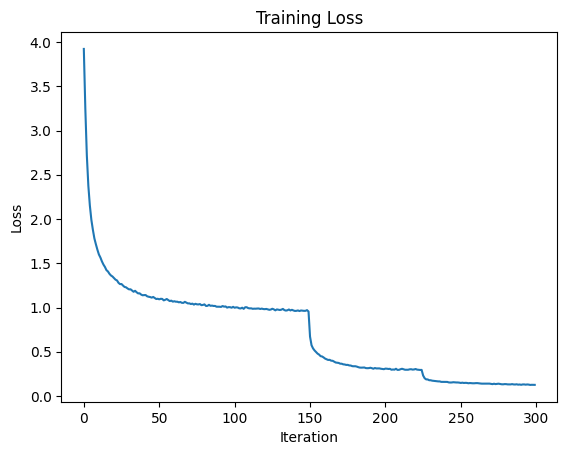

In [28]:
# DO NOT MODIFY THIS CODE
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

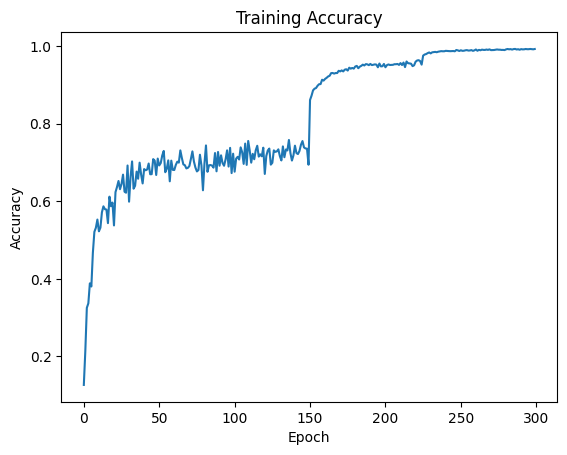

In [29]:
# DO NOT MODIFY THIS CODE
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

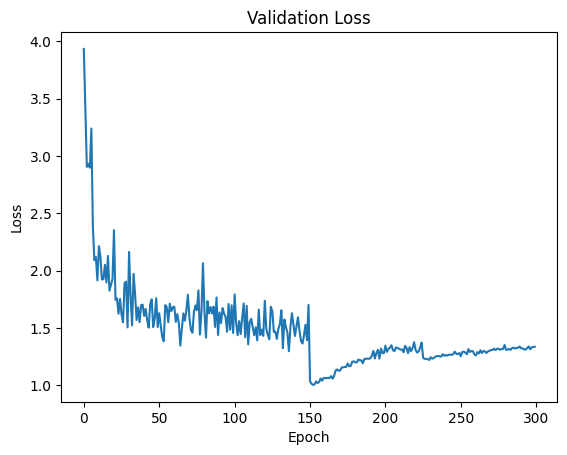

In [30]:
plt.plot(val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [31]:
# DO NOT MODIFY THIS CODE
test_accuracy = evaluate(net, cifar100_test)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.7402
